# Orient instruments using Rayleigh waves
Jupyter Notebook wrapper for the DLOPy_v1.0 codes. This package reads in event data directly from the IRIS database, so no need to worry about data formatting. By default, it assumes H2 is 90$^\circ$ CW from H1 with Z pointing up (left handed system). It uses global dispersion maps to predict the Rayleigh-wave arrival window. The cross-correlations are preformed in seven frequency bands ranging from 10 to 40 mHz (25-100 s).

### The output angle is the clockwise rotation in degrees from geographic North of the nominally north component (H1).


#### JBR - 2/5/18 Modified to allow looping through all stations in a network (set singlesta=0).

In [3]:
# -*- coding: utf-8 -*-
"""
PRIMARY ORIENTATION PROGRAM
ADRIAN. K. DORAN
GABI LASKE
VERSION 1.0
RELEASED APRIL 2017
"""

#########################
# Import necessary packages, functions, and parameter files
# from Orient_PF import *
from pysave.locfuns import *
from numpy import *
import os
from obspy.fdsn import Client
%matplotlib inline
#########################

/Users/russell/anaconda/lib/python3.5/site-packages/obspy/__init__.py:159: ObsPyDeprecationWarning: Module 'obspy.fdsn' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.clients.fdsn' instead.
  ObsPyDeprecationWarning)


In [19]:
"""
Parameter file for Orient
A. Doran and G. Laske
"""
#################
# REQUIRED INPUTS
#################

# STATION INFO
# ------------
# NETWORK CODE
NET="ZA" #"ZA"      
# STATION NAME  
STA=["B01","B02"] # "*" for all stations
# CHANNELS TO ORIENT 
CHA="BH?" #"BH?"     
# CHANNEL LOCATION  
LOC="*"         

####
##    IF USING LOCAL DATA
####

localdata=0
if localdata==1:
    from readlocal import *
    LF=getmsd1
####
##    
####

# If want to input own station lat and lon 
localcoords=0
if localcoords==1:
    inputlat=32.533617
    inputlon=-120.49978    

####
##
####

# DATE INFO
# Time frame in which to calculation orientaiton
#       Must be of form YYYY-MM-DD HH:MM:SS

time1= "2011-12-08T00:00:00" #"2011-12-08T00:00:00"     # Start date
time2= "2012-12-09T00:00:00" #"2012-12-09T00:00:00"     # End date

# CLIENT INFO
#       Where to download catalog and waveform data
cat_client="IRIS"       # catalog data
wf_client="IRIS"        # waveform data
# Other options according to OBSPY man page:
# ‘BGR’, ‘EMSC’, ‘ETH’, ‘GEONET’, ‘GFZ’, ‘INGV’, ‘IPGP’, 
# ‘IRIS’, ‘ISC’, ‘KOERI’, ‘LMU’, ‘NCEDC’, ‘NIEP’, ‘NOA’, 
# ‘ODC’, ‘ORFEUS’, ‘RESIF’, ‘SCEDC’, ‘USGS’, ‘USP’

# COORDINATE SYSTEM
nameconv=2
# Options for channel naming parameter
# 1 - HZ, HN, HE
# 2 - HZ + Left-handed system: H2 is 90 degs CW of H1 
# 3 - HZ + Right-handed system: H2 is 90 degs CCW of H1

# EQ SPECIFICATIONS
minmag=7.0 #7.0 # 6.5 # 5.5          # Minimum magniutde EQ used
mindeg_sw=5.0      # Minimum event degree distance for surface waves
maxdeg_sw=175.0    # Maximum event degree distance for surface waves
maxdep_sw=150.0     # Maximum event depth (km) for surface waves
    
# How much information to output while the program is running
verb=2
# 0 - outputs nothing
# 1 - outputs current event being analyzed out of total (eg 4 / 79)
# 2 - outputs event number and one result (R1-30)

# Save results along the way?
constsave=0
# 0 - no
# 1 - yes

# plot results at end?
finplot=1
# 0 - no
# 1 - yes

# save event catalog?
savecat=1
# 0 - no
# 1 - yes

# Resume from a previous station?
isresume = 0
STA_resume = 'B01'

In [20]:
client = Client(wf_client)
inventory = client.get_stations(network=NET, station=",".join(STA),channel=CHA, starttime=time1, endtime=time2)
STAS = [x.code for x in inventory[0].stations]
STAS

['B01',
 'B02',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B11',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'B20',
 'B21',
 'B22',
 'B23',
 'B24',
 'B25',
 'B26']

## DO NOT EDIT BELOW THIS POINT

Working on station: B01
B01: 1 / 17
R1-30 cc: 0.95   R1-30 phi: 289.92
B01: 2 / 17
R1-30 cc: 0.99   R1-30 phi: 276.59
B01: 3 / 17
R1-30 cc: 0.99   R1-30 phi: 279.46
B01: 5 / 17
R1-30 cc: 0.99   R1-30 phi: 286.87
B01: 6 / 17
R1-30 cc: 0.99   R1-30 phi: 275.90
B01: 7 / 17
R1-30 cc: 0.99   R1-30 phi: 285.57
B01: 9 / 17
R1-30 cc: 0.98   R1-30 phi: 284.63
B01: 10 / 17
R1-30 cc: 0.95   R1-30 phi: 283.56
B01: 11 / 17
R1-30 cc: 0.73   R1-30 phi: 271.79
B01: 12 / 17
R1-30 cc: 0.88   R1-30 phi: 269.52
B01: 13 / 17
R1-30 cc: 0.96   R1-30 phi: 265.16
B01: 14 / 17
R1-30 cc: 0.95   R1-30 phi: 299.52
B01: 15 / 17
R1-30 cc: 0.35   R1-30 phi: 314.89
B01: 17 / 17
R1-30 cc: 0.95   R1-30 phi: 283.86


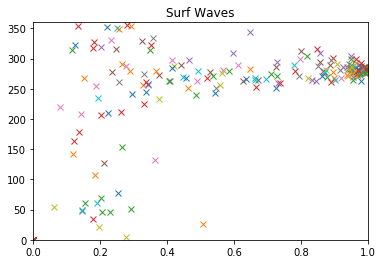

In [6]:
# Define variables using param file inputs1
client1=Client(cat_client)      # Catalog Client
client2=Client(wf_client)     # Waveform Client
t1=UTCDateTime(time1)           # start date
t2=UTCDateTime(time2)           # end date
cat=client1.get_events(starttime=t1,endtime=t2,minmagnitude=minmag)#,maxmagnitude=maxmag)

# Loop over stations
resumeflag = 0
for iSTA, STA in enumerate(STAS):
    print('Working on station: '+STA)
    if isresume==1 and resumeflag==0 and STA!=STA_resume :
        continue
    resumeflag = 1
    
    # Different save location? must be string
    saveloc= NET+'/'+STA+'/'
    catname=str(saveloc+STA+'.cat.txt')

    # get station info
    if localdata==1 or localcoords==1:
        sta_lat=inputlat
        sta_lon=inputlon
    else:
        # Get station and event data
        inv=client1.get_stations(network=NET,station=STA)
        sta_lat=inv[0][0].latitude
        sta_lon=inv[0][0].longitude

    # Organize station and event data
    # organize data from catalog
    L=len(cat.events)
    lat=zeros(L); lon=zeros(L); mag=zeros(L); stime=zeros(L); dep=zeros(L); deg=zeros(L); baz=zeros(L)
    for i in arange(L):
        lat[i]=cat.events[i].origins[0].latitude                            # latitude
        lon[i]=cat.events[i].origins[0].longitude                            # longitude
        dep[i]=cat.events[i].origins[0].depth                            # depth
        stime[i]=UTCDateTime(cat.events[i].origins[0].time)                # event start time
        mag[i]=cat.events[i].magnitudes[0].mag                            # magnitude
        #daz1=obspy.core.util.gps2DistAzimuth(sta_lat,sta_lon,lat[i],lon[i])   # depricated version
        daz1=obspy.geodetics.gps2dist_azimuth(sta_lat,sta_lon,lat[i],lon[i])   # distance b/t station and event
        #deg[i]=obspy.core.util.kilometer2degrees(daz1[0]/1000)                # depricated version
        deg[i]=obspy.geodetics.kilometer2degrees(daz1[0]/1000)               
        baz[i]=daz1[1]                                                     # angle from station to event
    # get index of repeat events, save for later
    reps=unique(catclean(stime,lat,lon,mag))

    # to save catalog:
    if not os.path.exists(NET):
        os.mkdir(NET)
    if not os.path.exists(saveloc):
        os.mkdir(saveloc)
    if savecat==1:
        ts=array([],dtype=object)
        h1=array(['Time','Lon','Lat','Dep(km)','Mag'],dtype=object)
        for i in arange(L):
            ts=append(ts,UTCDateTime(stime[i]))
        catprint2=array((ts,lon,lat,dep/1000,mag),dtype=object).T
        catprint=vstack((h1,catprint2))
        savetxt(catname,catprint,fmt="%s")

    #   INITIALIZE INITIALIZE
    # Initialize surface wave arrays
    numsurfcalcs=7
    R1phi=zeros([L,numsurfcalcs]); R1cc=zeros([L,numsurfcalcs])
    R2phi=zeros([L,numsurfcalcs]); R2cc=zeros([L,numsurfcalcs]);
    # Initialize Stachnik arrays
    R4phi=zeros((L)); R4cc=zeros((L))

    hrs=4*60*60     # Length of data to download

    # load group velocity maps
    map10=loadtxt('grv_disp/R.gv.10.txt'); map15=loadtxt('grv_disp/R.gv.15.txt')
    map20=loadtxt('grv_disp/R.gv.20.txt'); map25=loadtxt('grv_disp/R.gv.25.txt')
    map30=loadtxt('grv_disp/R.gv.30.txt'); map35=loadtxt('grv_disp/R.gv.35.txt')
    map40=loadtxt('grv_disp/R.gv.40.txt')

    #      LOOP OVER ALL EVENTS
    for j in arange((L)):

    #     GET WAVEFORMS, including protections
        try:
            if localdata==0:
                # download data from client
                s=client2.get_waveforms(NET,STA,LOC,CHA,UTCDateTime(stime[j]),UTCDateTime(stime[j]+hrs))
            else:
                # access local data
                s=LF(UTCDateTime(stime[j]))

            # merge waveforms (sometimes downloaded in several segments)
            s.merge()

            # don't want any masked data or data with nans
            for q in arange((len(s))):
                if ma.count_masked(s[q].data)>0:
                    continue

            # remove mean and trend
            s.detrend()
            s.detrend('linear')
            if len(s)<3:
                continue
            # [0] bh1, [1] bh2, [2] bhz
            st=org(s.copy(),nameconv) 
                # organizes data by coordinate system
                # also downsamples to <10 Hz

            # check data length, data quality        
            if checklen(st,hrs):
                continue

        except:
            continue

        # get some additional parameters
        #daz1=obspy.core.util.gps2DistAzimuth(sta_lat,sta_lon,lat[j],lon[j])
        daz1=obspy.geodetics.gps2dist_azimuth(sta_lat,sta_lon,lat[j],lon[j])
        daz2=copy(daz1)
        Rearth=6371.25*1000; circE=2*np.pi*Rearth;
        daz2[0]=circE-daz2[0]; daz2[1]=daz2[1]+180  # major & minor arc calculation
        if daz2[1]>=360: daz2[1]-=360

        # SURFACE WAVE CALCULATIONS

        # conditions
        # minimum distance, maximum distance, and maximum depth
        if deg[j]<mindeg_sw or deg[j]>maxdeg_sw or dep[j]>=maxdep_sw*1000:
            continue
        # clean catalog of repeats (repeat conditions set in catclean)
        if j in reps:
            continue

        # get path-averaged group velocities
        Ray1,Ray2=pathvels(sta_lat,sta_lon,lat[j],lon[j],map10,map15,map20,map25,map30,map35,map40)  
    #        
        # FOR EACH FREQUENCY AND ORBIT, calculate arrival angle

    ##    # freq 1 (40 mHz)
        Rf=40.0; HPF=0.035; LPF=0.045

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=20.0,ptype=0)
        R1phi[j,0]=ANG; R1cc[j,0]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=24.0,ptype=0)
        R2phi[j,0]=ANG; R2cc[j,0]=cc

    ##    # freq 2 (35 mHz)
        Rf=35.0; HPF=0.030; LPF=0.040
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=17.0,ptype=0)
        R1phi[j,1]=ANG; R1cc[j,1]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=20.0,ptype=0)
        R2phi[j,1]=ANG; R2cc[j,1]=cc

    #
    ###    # freq 3 (30 mHz)
        Rf=30.0; HPF=0.025; LPF=0.035
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=14.0,ptype=0)
        R1phi[j,2]=ANG; R1cc[j,2]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=16.0,ptype=0)
        R2phi[j,2]=ANG; R2cc[j,2]=cc


    # # # freq 4 (25 mHz)
        Rf=25.0; HPF=0.020; LPF=0.030
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=12.0,ptype=0)
        R1phi[j,3]=ANG; R1cc[j,3]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=13.0,ptype=0)
        R2phi[j,3]=ANG; R2cc[j,3]=cc

    ###    # freq 5 (20 mHz)
        Rf=20.0; HPF=0.015; LPF=0.025
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=10.0,ptype=0)
        R1phi[j,4]=ANG; R1cc[j,4]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=10.0,ptype=0)
        R2phi[j,4]=ANG; R2cc[j,4]=cc

    ###    # freq 6 (15 mHz)
        Rf=15.0; HPF=0.020; LPF=0.010
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=10.0,ptype=0)
        R1phi[j,5]=ANG; R1cc[j,5]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=10.0,ptype=0)
        R2phi[j,5]=ANG; R2cc[j,5]=cc

    ###    # freq 7 (10 mHz)
        Rf=10.0; HPF=0.005; LPF=0.015
    #
        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz1,Ray1,nameconv,winlen=7.0,ptype=0)
        R1phi[j,6]=ANG; R1cc[j,6]=cc

        ANG,cc=SW1(st.copy(),Rf,LPF,HPF,daz2,Ray2,nameconv,winlen=7.0,ptype=0)
        R2phi[j,6]=ANG; R2cc[j,6]=cc

    # save up that Data
        if constsave==1:
            saved(R1cc,R2cc,R1phi,R2phi,loc=str(saveloc))          

        # WHAT TO OUTPUT AT THE END OF EACH ITERATION
        if verb==1:
            # Just output number
            print("%s: %i / %i" %(STA,j+1,L))
        elif verb==2:
            print("%s: %i / %i" %(STA,j+1,L))
            print("R1-30 cc: %.2f   R1-30 phi: %.2f" %(R1cc[j,2],R1phi[j,2]))


    # PLOT ALL RESULTS
    if finplot==1:
        plt.figure()
        plt.subplot(1,1,1)
        plt.title('Surf Waves')
        plt.plot(R1cc,R1phi,'x',R2cc,R2phi,'x')
        plt.ylim([0,360]); plt.xlim([0,1])

    # SAVE DATA
    saved(R1cc,R2cc,R1phi,R2phi,loc=str(saveloc))

# compcalcs.py

Station ZA/B01/
D-L mean, error, data included, unique events: 281.08, 3.75, 87, 14
D-L CC level: 0.800000


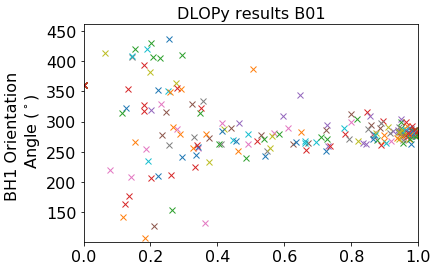

In [7]:
"""
Final Orientation Calculation File
A. Doran and G. Laske
"""

#####################
## ANGLE CALCULATION PARAMETERS
#####################

# open textfile to save to
fnet = open(NET+'/'+NET+'_orientations_long.txt','w')
fnet2 = open(NET+'/'+NET+'_orientations.txt','w')

# Loop over stations
for iSTA, STA in enumerate(STAS):

    # location of result files
    loc1= NET+'/'+STA+'/'

    LIM=0.8         # CC limit for Surface wave calculations

    #
    ### Specify phases to use
    R1use=1
    R1_40=1; R1_35=1; R1_30=1; R1_25=1; R1_20=1; R1_15=1; R1_10=1
    R2use=1
    R2_40=1; R2_35=1; R2_30=1; R2_25=1; R2_20=1; R2_15=1; R2_10=1
    #
    #

    ## Load files
    R1phi=loadtxt(loc1+'R1phi')
    R1cc=loadtxt(loc1+'R1cc')

    R2phi=loadtxt(loc1+'R2phi')
    R2cc=loadtxt(loc1+'R2cc')

    ######################
    ### FINAL ANGLE CALCULATIONS
    ######################
    #
    # Initialize arrays
    L=len(R1phi)
    phis=array([])
    ccs=array([])
    finval=array([]); finerr=array([])
    N=array([]); 

    N=full((L,L),-1.0)
    LN=zeros((L))
    phases=array([]);

    startL=0
    endL=0

    A=array([L])
    if endL!=0:
        A=array([endL])


    # If not all calculations are desired, adjust accordingly
    sha=shape(R1phi)
    if R1use==0: R1cc=zeros(sha)
    if R1use==1 and R1_40==0: R1cc[:,0]=zeros((sha[0]))
    if R1use==1 and R1_35==0: R1cc[:,1]=zeros((sha[0]))
    if R1use==1 and R1_30==0: R1cc[:,2]=zeros((sha[0]))
    if R1use==1 and R1_25==0: R1cc[:,3]=zeros((sha[0]))
    if R1use==1 and R1_20==0: R1cc[:,4]=zeros((sha[0]))
    if R1use==1 and R1_15==0: R1cc[:,5]=zeros((sha[0]))
    if R1use==1 and R1_10==0: R1cc[:,6]=zeros((sha[0]))

    if R2use==0: R2cc=zeros(sha)    
    if R2use==1 and R2_40==0: R2cc[:,0]=zeros((sha[0]))
    if R2use==1 and R2_35==0: R2cc[:,1]=zeros((sha[0]))
    if R2use==1 and R2_30==0: R2cc[:,2]=zeros((sha[0]))
    if R2use==1 and R2_25==0: R2cc[:,3]=zeros((sha[0]))
    if R2use==1 and R2_20==0: R2cc[:,4]=zeros((sha[0]))
    if R2use==1 and R2_15==0: R2cc[:,5]=zeros((sha[0]))
    if R2use==1 and R2_10==0: R2cc[:,6]=zeros((sha[0]))

    for i in A:
        # create one massive list with necessary angles and cc values
        phis=concatenate((flatten(R1phi[startL:i,:]),flatten(R2phi[startL:i,:])))
        ccs=concatenate((flatten(R1cc[startL:i,:]),flatten(R2cc[startL:i,:])))

        # Doran-Laske calculation
        val,err,n,ph=fcalc1(phis,ccs,LIM,R1cc,R2cc)
        finval=append(finval,val)
        finerr=append(finerr,err)
        phases=append(phases,ph)
        for k in arange((len(n))):
            N[k,i-1]=n[k]
        LN[i-1]=len(n)

    # output results to termianl
    print("Station %s" %(loc1))
    print("D-L mean, error, data included, unique events: %.2f, %.2f, %i, %i" %(finval[-1],finerr[-1],phases[-1],max(LN)))
    print("D-L CC level: %f" %(LIM))

    ###
    ###
    #####
    ###
    ###

    # create figure

    CEN=finval[-1]
    YLIM1=[-10+CEN,10+CEN]

    plt.figure()
    plt.subplot(1,1,1)
    plt.title('DLOPy results '+STA,fontsize=16)
    plt.plot(R1cc,centerat(R1phi,m=CEN),'x',R2cc,centerat(R2phi,m=CEN),'x')
    plt.ylabel('BH1 Orientation \n Angle ($^\circ$)',fontsize=16)
    plt.ylim([CEN-180,CEN+180]); plt.xlim([0,1])
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    # save figure
    plt.savefig(loc1+'cluster.eps',fmt='eps')

    # save orientation to station folder
    f = open(loc1+STA+'_orientation.txt','w')
    f.write('STA MEAN 4-SIG MEAS EVS\n')
    f.write("%s %.2f %.2f %i %i\n" % (STA, finval[-1], finerr[-1], phases[-1], max(LN)))
    f.close()

    # save list for all orientations
    if iSTA==0:
        fnet.write('STA MEAN 4-SIG MEAS EVS\n')
    fnet.write("%s %.2f %.2f %i %i\n" % (STA, finval[-1], finerr[-1], phases[-1], max(LN)))
    fnet2.write("%s %.2f\n" % (STA, finval[-1]))
fnet.close()
fnet2.close()
